In [1]:
!pip install simpy
import simpy
import random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class FMCGSupplyChain:
    def __init__(self, env):
        self.env = env
        self.iteration = 0  # Track iteration number
        self.fuel_price = 5  # Affected by energy provider
        self.electricity_stability = True  # Impacts cold storage and power outages
        self.economic_fluctuation = 1.0  # Market trend impact on demand

        # Dynamic inventory levels
        self.farmer_inventory = 0
        self.wholesaler_inventory = 0
        self.retailer_inventory = 0
        self.wholesaler_demand = 100  # Initial demand
        self.retailer_demand = 80  # Initial demand
        self.farmer_inventory_threshold = 150  # Max farmer inventory
        self.retailer_inventory_threshold = 150  # Max retailer inventory
        self.wholesaler_inventory_threshold = 300  # Max wholesaler inventory
        self.cold_storage_failure = False  # Affects produce quality
        self.farmer_waiting = False  # Track if farmer is waiting

        # NEW: Price tracking at each stage
        self.farmer_unit_cost = 0        # Production cost per unit
        self.farmer_selling_price = 0    # Price farmer sells to wholesaler
        self.wholesaler_unit_cost = 0    # Cost after wholesaler adds their costs
        self.wholesaler_selling_price = 0  # Price wholesaler sells to retailer
        self.retailer_unit_cost = 0      # Cost after retailer adds their costs
        self.retailer_selling_price = 0  # Final consumer price

        # Revenue tracking
        self.farmer_revenue = 0
        self.wholesaler_revenue = 0
        self.retailer_revenue = 0

        # Profit tracking
        self.farmer_profit = 0
        self.wholesaler_profit = 0
        self.retailer_profit = 0

        # Cost parameters
        self.farmer_cost = 0
        self.wholesaler_cost = 0
        self.retailer_cost = 0

        # Farmer attributes affecting costs
        self.land_fertility = 60  # Higher fertility reduces production costs
        self.weather_abnormality = False  # Weather issues increase costs
        self.soil_moisture = 40  # Low moisture increases irrigation costs
        self.yield_quality = 80  # Higher quality affects pricing
        self.market_accessibility = True  # Affects distribution costs

        # Supplier/Transport attributes affecting costs
        self.cold_storage_vehicle_failure = False  # Increases spoilage costs
        self.weather_unsuitability = False  # Affects transport efficiency
        self.transport_accidents = False  # Increases emergency costs
        self.route_efficiency = 70  # Higher efficiency reduces transport costs

        # Wholesaler attributes affecting costs
        self.labor_strike = False  # Increases labor costs
        self.storage_capacity_utilization = 0  # Percentage of capacity used
        self.product_damage_rate = 0.05  # Percentage of damaged products
        self.power_outages = False  # Increases operational costs

        # Distributor attributes affecting costs
        self.distribution_network_efficiency = 75  # Higher efficiency reduces costs
        self.inventory_fluctuations = False  # Affects holding costs
        self.product_loss_handling = 0.03  # Percentage of products lost in handling

        # Retailer attributes affecting costs
        self.demand_forecast_accuracy = 80  # Higher accuracy reduces overstocking costs
        self.waste_management_efficiency = 70  # Higher efficiency reduces waste costs

        # Markup percentages
        self.farmer_markup = 0.3     # 30% markup over production cost
        self.wholesaler_markup = 0.25  # 25% markup over purchase + handling cost
        self.retailer_markup = 0.40   # 40% markup over purchase + handling cost

        # Tracking data for visualization
        self.time_log = []
        self.farmer_inventory_log = []
        self.wholesaler_inventory_log = []
        self.retailer_inventory_log = []
        self.farmer_cost_log = []
        self.wholesaler_cost_log = []
        self.retailer_cost_log = []
        # NEW: Price tracking logs
        self.farmer_price_log = []
        self.wholesaler_price_log = []
        self.retailer_price_log = []
        # NEW: Revenue and profit logs
        self.farmer_revenue_log = []
        self.wholesaler_revenue_log = []
        self.retailer_revenue_log = []
        self.farmer_profit_log = []
        self.wholesaler_profit_log = []
        self.retailer_profit_log = []

    def log_event(self, message):
        print(f"Iteration {self.iteration} | Time {self.env.now}: {message}")

        # Log inventory levels and costs
        self.time_log.append(self.env.now)
        self.farmer_inventory_log.append(self.farmer_inventory)
        self.wholesaler_inventory_log.append(self.wholesaler_inventory)
        self.retailer_inventory_log.append(self.retailer_inventory)
        self.farmer_cost_log.append(self.farmer_cost)
        self.wholesaler_cost_log.append(self.wholesaler_cost)
        self.retailer_cost_log.append(self.retailer_cost)
        # NEW: Log prices
        self.farmer_price_log.append(self.farmer_selling_price)
        self.wholesaler_price_log.append(self.wholesaler_selling_price)
        self.retailer_price_log.append(self.retailer_selling_price)
        # NEW: Log revenue and profit
        self.farmer_revenue_log.append(self.farmer_revenue)
        self.wholesaler_revenue_log.append(self.wholesaler_revenue)
        self.retailer_revenue_log.append(self.retailer_revenue)
        self.farmer_profit_log.append(self.farmer_profit)
        self.wholesaler_profit_log.append(self.wholesaler_profit)
        self.retailer_profit_log.append(self.retailer_profit)

    def produce_goods(self, land_fertility, weather_abnormality, soil_moisture, govt_subsidy):
        self.iteration += 1
        if self.farmer_inventory >= self.farmer_inventory_threshold:
            self.farmer_waiting = True
            self.log_event("Farmer inventory full, waiting for wholesaler and retailer to clear stock.")
            yield self.env.timeout(2)  # Wait before checking again
            yield self.env.process(self.transport_goods())

        self.farmer_waiting = False
        production_time = max(1, 5 - land_fertility // 10)
        if weather_abnormality:
            production_time += 2
        if soil_moisture < 30:
            production_time += 1
        if govt_subsidy:
            production_time -= 1  # Government subsidies improve efficiency
        yield self.env.timeout(production_time)
        produced_quantity = min(self.farmer_inventory_threshold-self.farmer_inventory,random.randint(50, 150)) # Variable yield
        self.farmer_inventory += produced_quantity

        # Calculate production costs based on attributes
        base_cost_per_unit = 2.0
        fertility_factor = 1.0 - (land_fertility / 100) * 0.3  # Up to 30% reduction with perfect fertility
        weather_factor = 1.3 if weather_abnormality else 1.0  # 30% increase during bad weather
        moisture_factor = 1.2 if soil_moisture < 30 else 1.0  # 20% increase with low moisture
        subsidy_factor = 0.8 if govt_subsidy else 1.0  # 20% reduction with subsidies

        # NEW: Calculate unit cost instead of total cost
        self.farmer_unit_cost = base_cost_per_unit * fertility_factor * weather_factor * moisture_factor * subsidy_factor
        production_cost = produced_quantity * self.farmer_unit_cost
        self.farmer_cost += production_cost

        # NEW: Calculate farmer's selling price with markup
        self.farmer_selling_price = self.farmer_unit_cost * (1 + self.farmer_markup)

        self.log_event(f"Farmer produced {produced_quantity} units at cost ${self.farmer_unit_cost:.2f}/unit " +
                      f"(selling at ${self.farmer_selling_price:.2f}/unit). Farmer Inventory: {self.farmer_inventory}")
        yield self.env.process(self.transport_goods())

    def transport_goods(self):
        transport_time = random.randint(2, 6)
        if self.cold_storage_failure:
            transport_time += 3
        yield self.env.timeout(transport_time)
        if self.wholesaler_inventory < self.wholesaler_inventory_threshold:
            transported_quantity = min(self.farmer_inventory, self.wholesaler_demand, self.wholesaler_inventory_threshold - self.wholesaler_inventory)

            # NEW: Calculate transport cost per unit
            base_transport_cost = 1.0
            fuel_factor = self.fuel_price / 5.0  # Normalize to baseline of 5
            cold_storage_factor = 1.5 if self.cold_storage_failure else 1.0  # 50% increase with failures
            weather_factor = 1.2 if self.weather_unsuitability else 1.0  # 20% increase in bad weather
            accident_factor = 1.4 if self.transport_accidents else 1.0  # 40% increase with accidents
            route_efficiency_factor = 1.3 - (self.route_efficiency / 100)  # Up to 30% reduction with perfect efficiency
            market_access_factor = 1.0 if self.market_accessibility else 1.3  # 30% increase with poor access

            transport_cost_per_unit = base_transport_cost * fuel_factor * cold_storage_factor * weather_factor * accident_factor * (1 + route_efficiency_factor) * market_access_factor
            total_transport_cost = transport_cost_per_unit * transported_quantity

            # NEW: Transaction between farmer and wholesaler
            transaction_amount = transported_quantity * self.farmer_selling_price
            self.farmer_revenue += transaction_amount

            # NEW: Update wholesaler costs to include purchase price
            self.wholesaler_cost += transaction_amount

            # NEW: Calculate wholesaler's unit cost (purchase price + transport cost)
            self.wholesaler_unit_cost = self.farmer_selling_price + transport_cost_per_unit

            # NEW: Calculate wholesaler's selling price with markup
            self.wholesaler_selling_price = self.wholesaler_unit_cost * (1 + self.wholesaler_markup)

            # Update inventory levels
            self.farmer_inventory -= transported_quantity
            self.wholesaler_inventory += transported_quantity

            # Calculate farmer's profit
            self.farmer_profit = self.farmer_revenue - self.farmer_cost

            self.log_event(f"Wholesaler purchased {transported_quantity} units from farmer at " +
                          f"${self.farmer_selling_price:.2f}/unit (${transaction_amount:.2f} total). " +
                          f"Transport cost: ${total_transport_cost:.2f}. " +
                          f"Wholesaler Inventory: {self.wholesaler_inventory}")
            yield self.env.process(self.store_goods())
        else:
            self.log_event("Wholesaler inventory full, skipping transport. Waiting for retailer sales.")
            yield self.env.process(self.sell_goods())

    def store_goods(self):
        storage_time = random.randint(1, 4)
        if not self.electricity_stability:
            storage_time += 2  # Power outages affect storage time
        yield self.env.timeout(storage_time)

        # Calculate storage costs based on attributes
        inventory_level = self.wholesaler_inventory
        self.storage_capacity_utilization = inventory_level / self.wholesaler_inventory_threshold * 100

        # NEW: Calculate storage cost per unit
        base_storage_cost_per_unit = 0.5
        electricity_factor = 1.3 if not self.electricity_stability else 1.0  # 30% increase during outages
        labor_factor = 1.4 if self.labor_strike else 1.0  # 40% increase during strikes
        damage_cost_per_unit = self.product_damage_rate * 5  # Cost of damaged goods
        power_outage_factor = 1.2 if self.power_outages else 1.0  # 20% increase during power outages

        storage_cost_per_unit = base_storage_cost_per_unit * electricity_factor * labor_factor * power_outage_factor + damage_cost_per_unit
        total_storage_cost = storage_cost_per_unit * inventory_level
        self.wholesaler_cost += total_storage_cost

        # NEW: Update wholesaler's unit cost and selling price
        self.wholesaler_unit_cost += storage_cost_per_unit
        self.wholesaler_selling_price = self.wholesaler_unit_cost * (1 + self.wholesaler_markup)

        self.log_event(f"Wholesaler stored goods at cost ${storage_cost_per_unit:.2f}/unit. " +
                      f"New selling price: ${self.wholesaler_selling_price:.2f}/unit. " +
                      f"Wholesaler Inventory: {self.wholesaler_inventory}")
        yield self.env.process(self.distribute_goods())

    def distribute_goods(self):
        distribution_time = random.randint(2, 5)
        yield self.env.timeout(distribution_time)
        if self.retailer_inventory < self.retailer_inventory_threshold:
            if self.wholesaler_inventory > 0:
                distributed_quantity = min(self.wholesaler_inventory, self.retailer_demand, self.retailer_inventory_threshold - self.retailer_inventory)

                # NEW: Calculate distribution cost per unit
                base_distribution_cost = 0.8
                network_efficiency_factor = 1.2 - (self.distribution_network_efficiency / 100)  # Up to 20% reduction with perfect efficiency
                fluctuation_factor = 1.15 if self.inventory_fluctuations else 1.0  # 15% increase with fluctuations
                handling_loss_cost = self.product_loss_handling * 4  # Cost of lost products
                fuel_factor = self.fuel_price / 5.0  # Normalize to baseline of 5

                distribution_cost_per_unit = base_distribution_cost * (1 + network_efficiency_factor) * fluctuation_factor * fuel_factor + handling_loss_cost
                total_distribution_cost = distribution_cost_per_unit * distributed_quantity

                # NEW: Transaction between wholesaler and retailer
                transaction_amount = distributed_quantity * self.wholesaler_selling_price
                self.wholesaler_revenue += transaction_amount

                # NEW: Update retailer costs to include purchase price
                self.retailer_cost += transaction_amount

                # NEW: Calculate retailer's unit cost (purchase price + distribution cost)
                self.retailer_unit_cost = self.wholesaler_selling_price + distribution_cost_per_unit

                # NEW: Calculate retailer's selling price with markup
                self.retailer_selling_price = self.retailer_unit_cost * (1 + self.retailer_markup)

                # Update inventory levels
                self.wholesaler_inventory -= distributed_quantity
                self.retailer_inventory += distributed_quantity

                # Calculate wholesaler's profit
                self.wholesaler_profit = self.wholesaler_revenue - self.wholesaler_cost

                self.log_event(f"Retailer purchased {distributed_quantity} units from wholesaler at " +
                              f"${self.wholesaler_selling_price:.2f}/unit (${transaction_amount:.2f} total). " +
                              f"Distribution cost: ${total_distribution_cost:.2f}. " +
                              f"Retailer Inventory: {self.retailer_inventory}")

                # Check if farmer can resume production
                if self.farmer_waiting and self.farmer_inventory < self.farmer_inventory_threshold:
                    self.log_event("Space cleared, farmer resumes production!")
                    yield self.env.process(self.produce_goods(self.land_fertility, self.weather_abnormality, self.soil_moisture, True))
            else:
                self.log_event("Wholesaler out of stock! Retailer must wait for new supply.")
                yield self.env.process(self.produce_goods(self.land_fertility, self.weather_abnormality, self.soil_moisture, True))
        else:
            self.log_event("Retailer inventory full, wholesaler waits!")
        yield self.env.process(self.sell_goods())

    def sell_goods(self):
        selling_time = random.randint(1, 3)
        yield self.env.timeout(selling_time)

        # Calculate demand based on price elasticity
        base_demand = random.randint(20, 200)
        price_elasticity = 0.5  # Demand decreases as price increases
        adjusted_demand = base_demand * (1 - price_elasticity * (self.retailer_selling_price / 10 - 1))
        sold_quantity = min(self.retailer_inventory, max(10, int(adjusted_demand)))

        # NEW: Calculate retail handling cost per unit
        base_retail_cost_per_unit = 0.7
        forecast_accuracy_factor = 1.2 - (self.demand_forecast_accuracy / 100)  # Up to 20% reduction with perfect forecasting
        waste_factor = 1.15 - (self.waste_management_efficiency / 100) * 0.3  # Up to 30% reduction with perfect waste management
        retail_handling_cost_per_unit = base_retail_cost_per_unit * (1 + forecast_accuracy_factor) * waste_factor

        # Update inventory and costs
        self.retailer_inventory -= sold_quantity
        retail_handling_cost = retail_handling_cost_per_unit * self.retailer_inventory  # Cost for remaining inventory
        self.retailer_cost += retail_handling_cost

        # NEW: Calculate retailer revenue and profit
        transaction_amount = sold_quantity * self.retailer_selling_price
        self.retailer_revenue += transaction_amount
        self.retailer_profit = self.retailer_revenue - self.retailer_cost

        self.log_event(f"Retailer sold {sold_quantity} units at ${self.retailer_selling_price:.2f}/unit " +
                      f"(${transaction_amount:.2f} total). " +
                      f"Remaining inventory handling cost: ${retail_handling_cost:.2f}. " +
                      f"Retailer Inventory: {self.retailer_inventory}")

        if self.retailer_inventory < 50:
            self.log_event("Retailer inventory low, placing new order!")
            yield self.env.process(self.distribute_goods())

        yield self.env.process(self.produce_goods(self.land_fertility, self.weather_abnormality, self.soil_moisture, True))



Iteration 1 | Time 0: Farmer produced 135 units at cost $1.31/unit (selling at $1.71/unit). Farmer Inventory: 135
Iteration 1 | Time 2: Wholesaler purchased 100 units from farmer at $1.71/unit ($170.56 total). Transport cost: $160.00. Wholesaler Inventory: 100
Iteration 1 | Time 4: Wholesaler stored goods at cost $0.75/unit. New selling price: $5.07/unit. Wholesaler Inventory: 100
Iteration 1 | Time 8: Retailer purchased 80 units from wholesaler at $5.07/unit ($405.56 total). Distribution cost: $102.40. Retailer Inventory: 80
Iteration 1 | Time 10: Retailer sold 28 units at $8.89/unit ($248.90 total). Remaining inventory handling cost: $47.90. Retailer Inventory: 52
Iteration 2 | Time 10: Farmer produced 115 units at cost $1.31/unit (selling at $1.71/unit). Farmer Inventory: 150
Iteration 2 | Time 14: Wholesaler purchased 100 units from farmer at $1.71/unit ($170.56 total). Transport cost: $160.00. Wholesaler Inventory: 120
Iteration 2 | Time 17: Wholesaler stored goods at cost $0.75/u

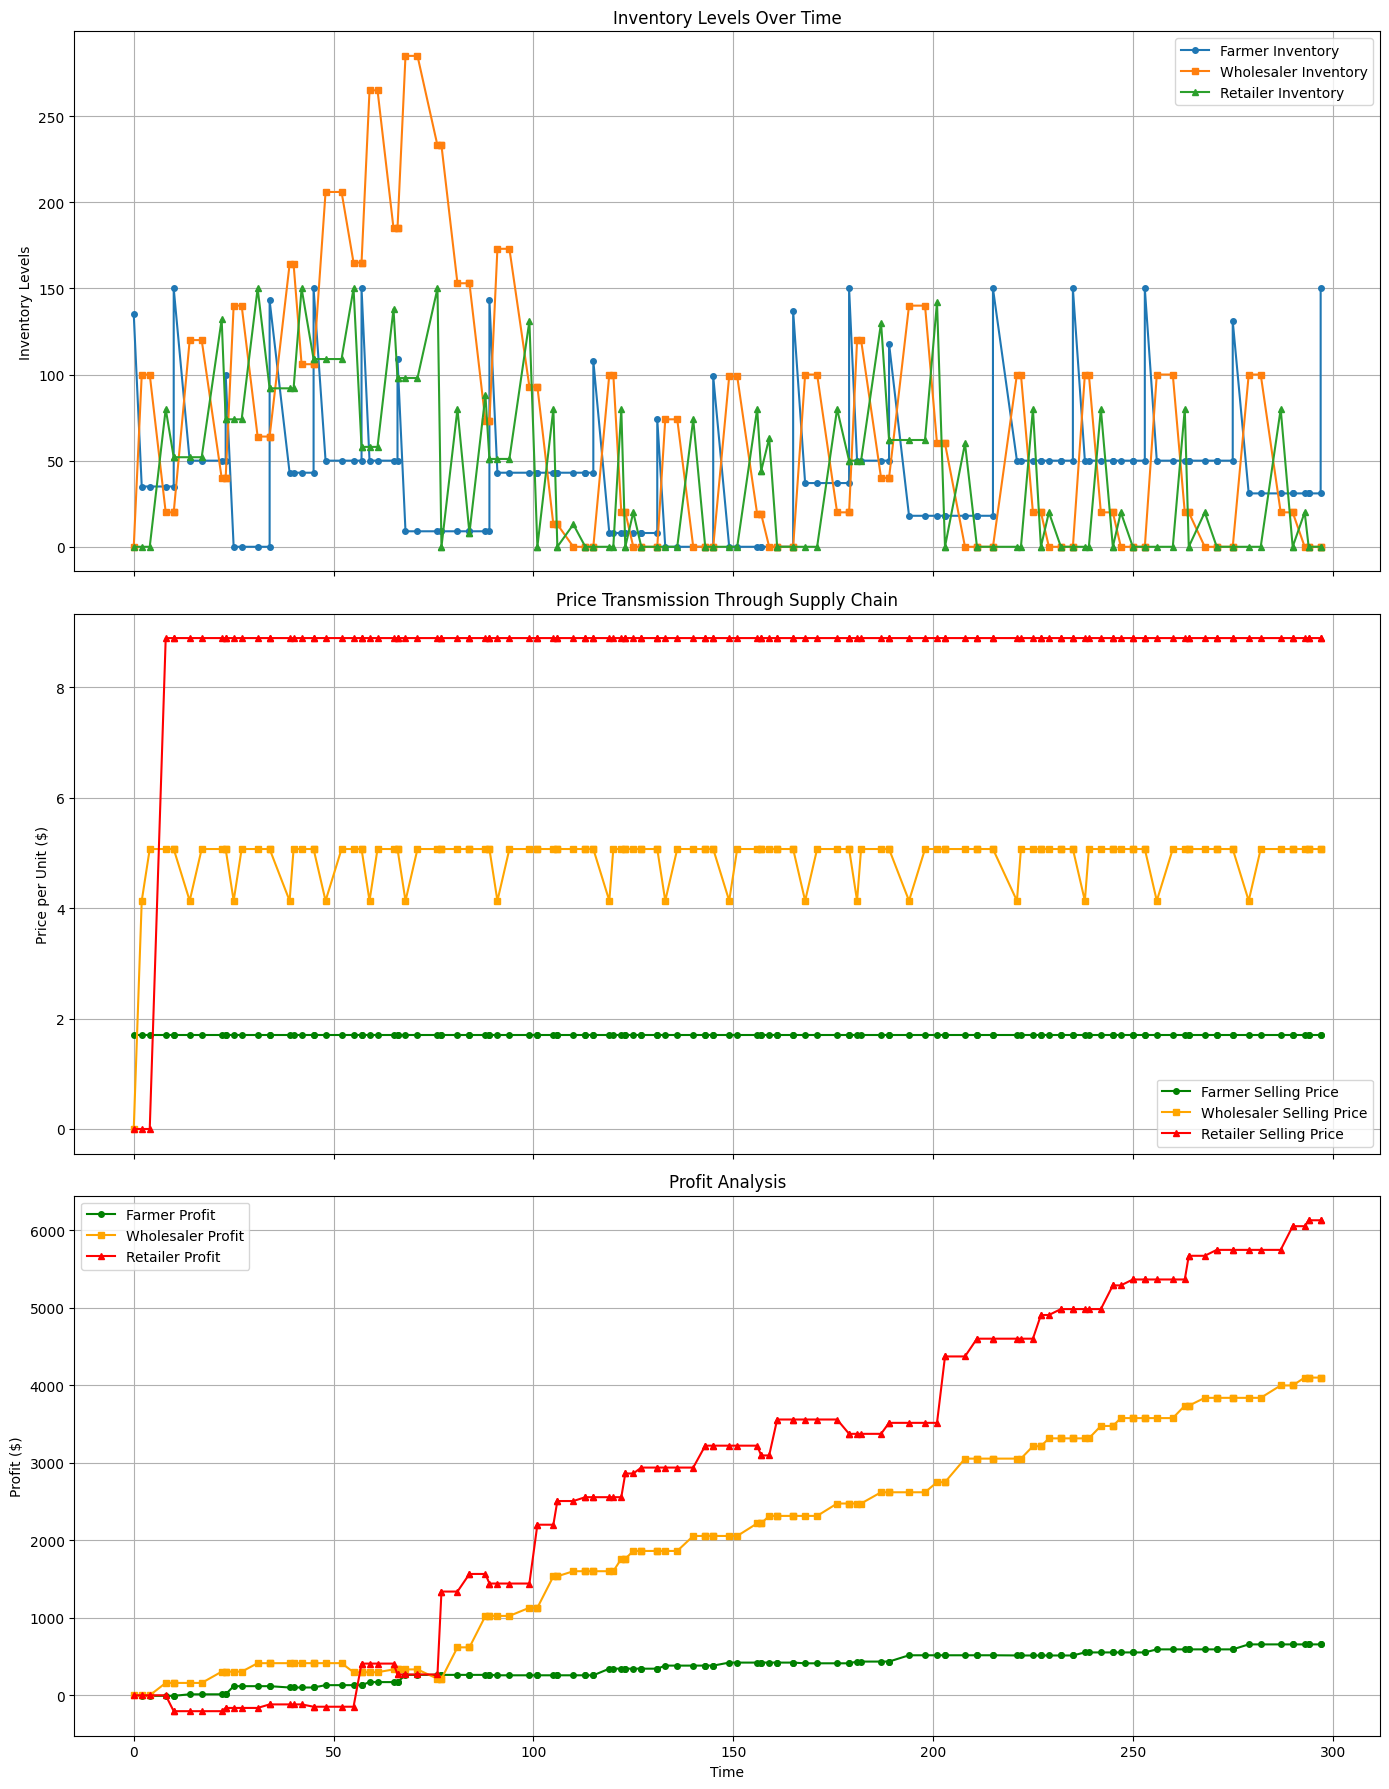

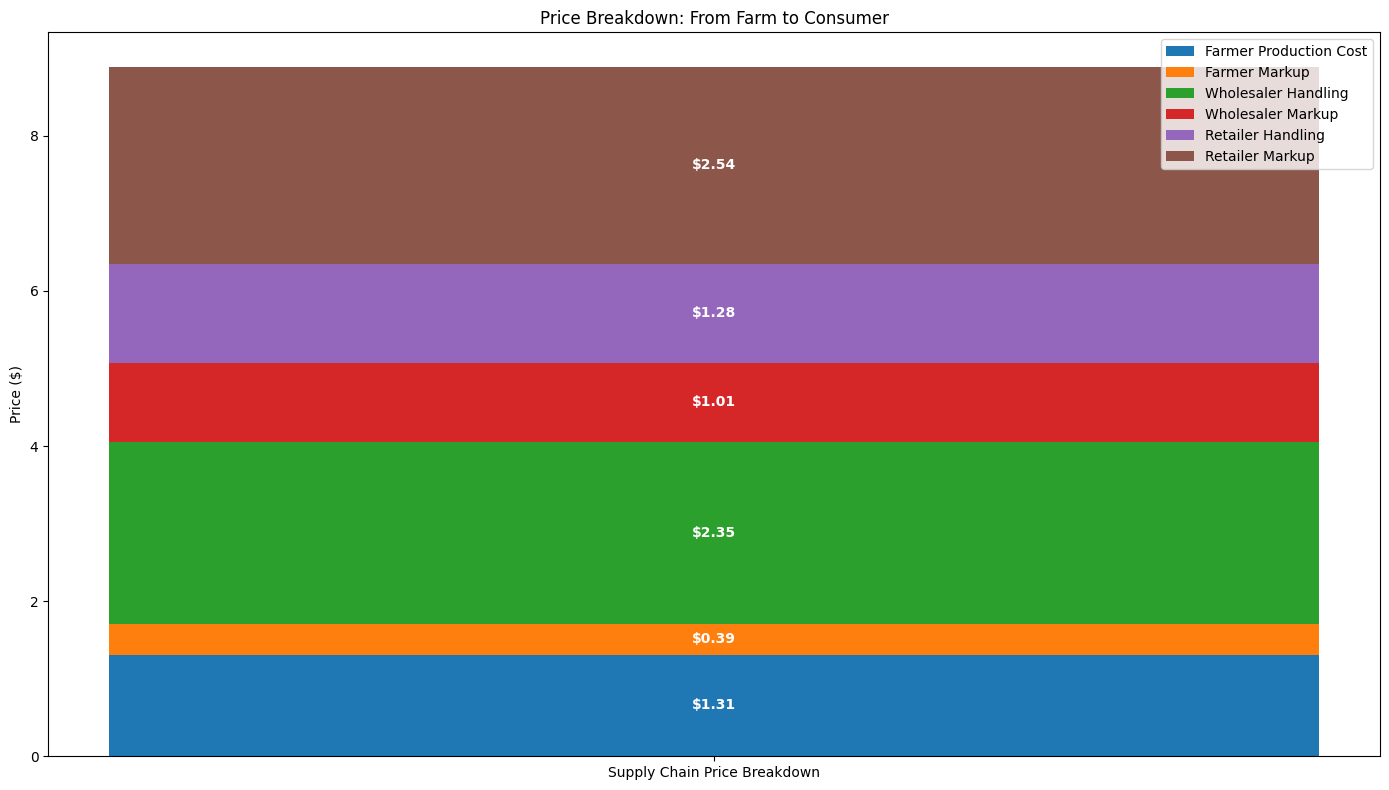

In [3]:
# Running the simulation
env = simpy.Environment()
supply_chain = FMCGSupplyChain(env)
env.process(supply_chain.produce_goods(60, False, 40, True))
env.run(until=300)  # Run for 300 time units

# Visualization - create a figure with multiple subplots
fig, axs = plt.subplots(3, 1, figsize=(14, 18), sharex=True)

# Plot inventory levels
axs[0].plot(supply_chain.time_log, supply_chain.farmer_inventory_log, label='Farmer Inventory', marker='o', markersize=4)
axs[0].plot(supply_chain.time_log, supply_chain.wholesaler_inventory_log, label='Wholesaler Inventory', marker='s', markersize=4)
axs[0].plot(supply_chain.time_log, supply_chain.retailer_inventory_log, label='Retailer Inventory', marker='^', markersize=4)
axs[0].set_ylabel("Inventory Levels")
axs[0].set_title("Inventory Levels Over Time")
axs[0].legend()
axs[0].grid(True)

# Plot unit prices
axs[1].plot(supply_chain.time_log, supply_chain.farmer_price_log, label='Farmer Selling Price', marker='o', color='green', markersize=4)
axs[1].plot(supply_chain.time_log, supply_chain.wholesaler_price_log, label='Wholesaler Selling Price', marker='s', color='orange', markersize=4)
axs[1].plot(supply_chain.time_log, supply_chain.retailer_price_log, label='Retailer Selling Price', marker='^', color='red', markersize=4)
axs[1].set_ylabel("Price per Unit ($)")
axs[1].set_title("Price Transmission Through Supply Chain")
axs[1].legend()
axs[1].grid(True)

# Plot profits
axs[2].plot(supply_chain.time_log, supply_chain.farmer_profit_log, label='Farmer Profit', marker='o', color='green', markersize=4)
axs[2].plot(supply_chain.time_log, supply_chain.wholesaler_profit_log, label='Wholesaler Profit', marker='s', color='orange', markersize=4)
axs[2].plot(supply_chain.time_log, supply_chain.retailer_profit_log, label='Retailer Profit', marker='^', color='red', markersize=4)
axs[2].set_xlabel("Time")
axs[2].set_ylabel("Profit ($)")
axs[2].set_title("Profit Analysis")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

# Additional visualization - price breakdown
fig, ax = plt.subplots(figsize=(14, 8))

# Use the final values from the simulation
final_idx = -1
farmer_cost = supply_chain.farmer_unit_cost
farmer_markup_amount = supply_chain.farmer_selling_price - farmer_cost
wholesaler_handling = supply_chain.wholesaler_unit_cost - supply_chain.farmer_selling_price
wholesaler_markup_amount = supply_chain.wholesaler_selling_price - supply_chain.wholesaler_unit_cost
retailer_handling = supply_chain.retailer_unit_cost - supply_chain.wholesaler_selling_price
retailer_markup_amount = supply_chain.retailer_selling_price - supply_chain.retailer_unit_cost

# Create stacked bar chart
categories = ['Supply Chain Price Breakdown']
width = 0.35
p1 = ax.bar(categories, [farmer_cost], width, label='Farmer Production Cost')
p2 = ax.bar(categories, [farmer_markup_amount], width, bottom=[farmer_cost], label='Farmer Markup')
p3 = ax.bar(categories, [wholesaler_handling], width, bottom=[farmer_cost+farmer_markup_amount], label='Wholesaler Handling')
p4 = ax.bar(categories, [wholesaler_markup_amount], width, bottom=[farmer_cost+farmer_markup_amount+wholesaler_handling], label='Wholesaler Markup')
p5 = ax.bar(categories, [retailer_handling], width, bottom=[farmer_cost+farmer_markup_amount+wholesaler_handling+wholesaler_markup_amount], label='Retailer Handling')
p6 = ax.bar(categories, [retailer_markup_amount], width, bottom=[farmer_cost+farmer_markup_amount+wholesaler_handling+wholesaler_markup_amount+retailer_handling], label='Retailer Markup')

# Add value labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_y() + height/2.,
                f'${height:.2f}', ha='center', va='center', color='white', fontweight='bold')

add_labels(p1)
add_labels(p2)
add_labels(p3)
add_labels(p4)
add_labels(p5)
add_labels(p6)

ax.set_ylabel('Price ($)')
ax.set_title('Price Breakdown: From Farm to Consumer')
ax.legend()

plt.tight_layout()
plt.show()